# Mapping Houston Real Estate Data using Python and Basemap (Zillow Data)

In this notebook I am going to use real estate historical price data downloaded from Zillow to visualize changes in single family residences within Houston area. 

The data required for this notebook are:
* Zip_Zhvi_SingleFamilyResidence.csv: Single family residence price data downloaded from Zillow data research. This file is downloaded from [Zillow Data Research](https://www.zillow.com/research/data/). **Since this file is larger than 25 MB. You can download this file and run it on your own machine.**
* Zip_Codes shape file that contains zip codes from greater Houston area. This file is used to plot zip codes maps using Matplotlib and Basemap. This file is downloaded from [City of Houston Open Data Website](https://cohgis-mycity.opendata.arcgis.com/datasets/zip-codes)
* cities_population_data.csv: US Census population data. This file used to compare Huston Population to other crities in US. This file is downloaded from [US Cenus Website](https://www.census.gov/data/tables/2017/demo/popest/total-cities-and-towns.html)

My aim was to answer following questions regarding real estate market in Houston, specially single-family housing.

In [1]:
import shapefile
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
from matplotlib import cm
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

In [2]:
# Overview of the data
ZillowData=pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv',encoding = "ISO-8859-1")
ZillowData.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,334200.0,335400.0,336500.0,...,1028800,1035200,1039500,1041800,1044200,1045300,1045700,1047800,1051200,1054500
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,...,322900,326700,330400,332500,334400,335700,336900,338200,338300,337300
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,498100.0,500900.0,503100.0,...,1310500,1317000,1321400,1325400,1328600,1326600,1324400,1324500,1323600,1323500
3,93144,79936,El Paso,TX,El Paso,El Paso County,4,77300.0,77300.0,77300.0,...,120400,120500,120700,121300,122200,122900,123500,124500,125600,126200
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,95400.0,95600.0,95800.0,...,173500,174700,175600,176500,176900,176900,177200,177900,178500,179200


### Question: What zip codes in Houston experienced largest increase/decrease in price of single family residences (2017-2018)?

In [3]:
# read pandas data then filter and group by  inorder we can get appropriate dataset for visualization
def FindPriceChange(csvData, StartYear,EndYear,CountyName,State):
    data_rearranged = pd.melt(csvData, id_vars=['RegionID','RegionName','City','State','Metro','CountyName','SizeRank',],\
               var_name='Date', value_name="Price")
    data_rearranged[['Year','Month']] = data_rearranged['Date'].str.split('-',expand=True)
    data_export=data_rearranged
    
    data_rearranged=data_rearranged[(data_rearranged['CountyName']==CountyName) & (data_rearranged['State']==State)]
    data_rearranged=data_rearranged[(data_rearranged['Year']==str(StartYear)) | (data_rearranged['Year']==str(EndYear)) ]
    
    dStartYear=data_rearranged[data_rearranged['Year']==StartYear].sort_values('RegionName')
    dEndYear=data_rearranged[data_rearranged['Year']==EndYear].sort_values('RegionName')

    dStartYear=dStartYear.groupby(['RegionName']).mean()
    dEndYear=dEndYear.groupby(['RegionName']).mean()
    PCT_Change=np.round(pd.DataFrame((dEndYear['Price']-dStartYear['Price'])*100/dStartYear['Price']),1)
    PCT_Change.columns =['PriceChange']
    PCT_Change=PCT_Change.reset_index()
    return PCT_Change,data_export


In [4]:
def PltShapeFile(PCT_Change,ShapeFileNamePath,StartYear,EndYear):
    shp_info  = shapefile.Reader(ShapeFileNamePath)
    fig=plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    # I am going to use constant colorbar scale for all plots
    #Min=PCT_Change['PriceChange'].min()
    #Max=PCT_Change['PriceChange'].max()
    Min=-10
    Max=20
    levels=12
    bounds = np.linspace(int(Min*1.1),int(Max*1.1),num=levels)
    
    cmap=cm.RdYlGn 
    col1 = cmap(np.linspace(0,1,num=levels))

    # draw a basemap of Houston Texas
    m = Basemap(llcrnrlon= -95.874390,llcrnrlat= 29.398927,urcrnrlon=-94.868042,urcrnrlat=30.206861,
                 resolution='h', projection='tmerc', lat_0 = 29.452034821862025, lon_0 = -95.41406270116569)

    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='#808080',lake_color='aqua')
    m.drawcoastlines()

    # create line connections and assign colors
    shapes = shp_info.shapes()
    records = shp_info.records()
    field_names = []
    for f in shp_info.fields[1:]:
        field_names.append((f[0]))

    # now color counties based on pct of price change values
    for record, shape in zip(records,shapes):
        lons,lats = zip(*shape.points)
        data = np.array(m(lons, lats)).T
        fields_of2 = dict(zip(field_names, record))
        Map_ZipCode=fields_of2['ZIP_CODE']
        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])
        lines = LineCollection(segs,antialiaseds=(1,))    
        try:
            Z_=PCT_Change.loc[PCT_Change['RegionName']==Map_ZipCode].index[0] 
            Z=int(np.interp(PCT_Change['PriceChange'].iloc[Z_], bounds,range(0,len(bounds)) ))
            lines.set_facecolors(col1[Z])
        except:
            # not found in database
            lines.set_facecolors('tab:gray')
        lines.set_edgecolors('w')
        lines.set_linewidth(1)
        ax.add_collection(lines)
    # add colorbar to map
    mm = plt.cm.ScalarMappable(cmap=cmap)
    mm.set_array([int(Min), int(Max)])
    cb=plt.colorbar(mm,ticks=np.round(bounds,0),orientation="vertical",fraction=0.042, pad=0.046).set_label(label='% Price Change',size=18,weight='bold')
    ax.tick_params(direction='out', length=6, width=2, colors='r',grid_color='r', grid_alpha=0.5)
    plt.title('% Price Change of Single Family Residence\n Houston, TX ('+ StartYear+ '-'+EndYear+', Data: Zillow)',size=18,weight='bold')
    plt.gca().axis("off")
    plt.show()

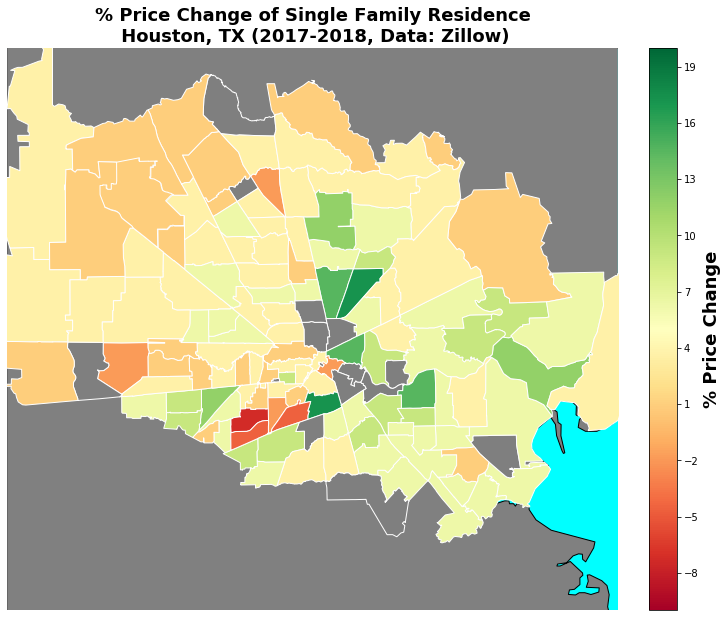

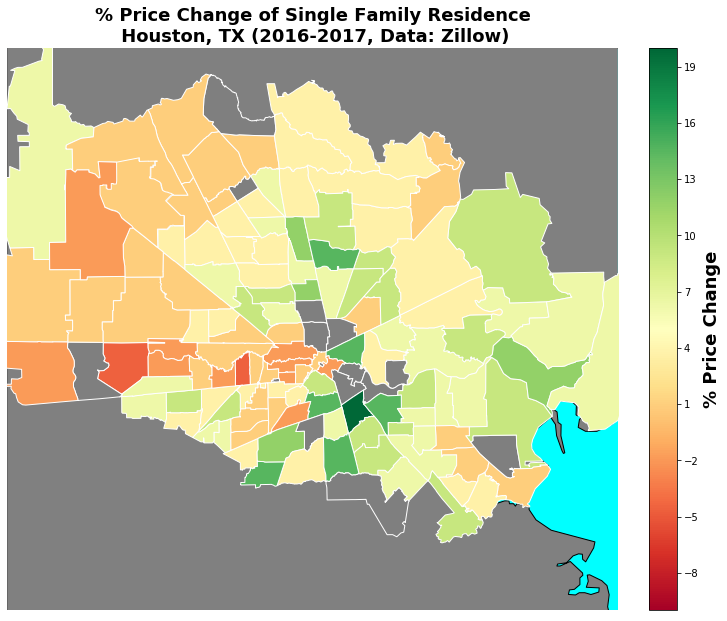

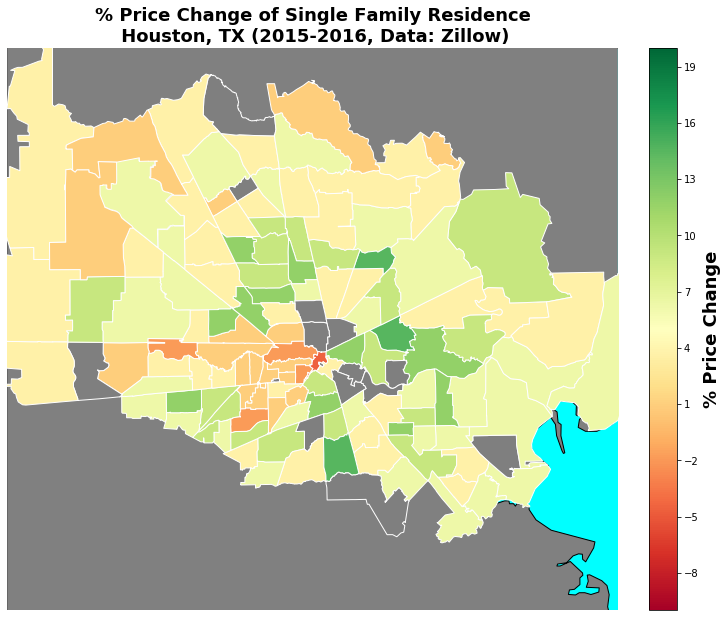

In [5]:
# now lets plot some data
csvData=pd.read_csv('Zip_Zhvi_SingleFamilyResidence.csv',encoding = "ISO-8859-1")
StartYear=str(2017)
EndYear=str(2018)
pt2018,data_rearranged=FindPriceChange(csvData,StartYear,EndYear,'Harris County','TX')
PltShapeFile(pt2018,'./shapefile/Zip_Codes',StartYear,EndYear)

StartYear=str(2016)
EndYear=str(2017)
pt2017,data_rearranged=FindPriceChange(csvData,StartYear,EndYear,'Harris County','TX')
PltShapeFile(pt2017,'./shapefile/Zip_Codes',StartYear,EndYear)

StartYear=str(2015)
EndYear=str(2016)
pt2016,data_rearranged=FindPriceChange(csvData,StartYear,EndYear,'Harris County','TX')
PltShapeFile(pt2016,'./shapefile/Zip_Codes',StartYear,EndYear)

C:\Users\Dr.Amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


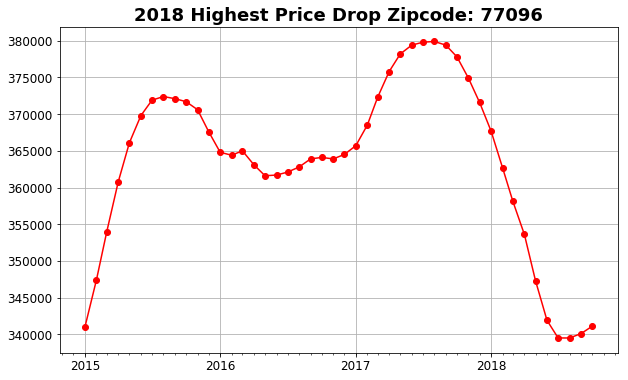

In [6]:
#So lets find out the zip code with highest price drop 
fig, ax = plt.subplots(figsize=(10,6))
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
pt2018=pt2018.sort_values(by=['PriceChange'])
data_rearranged['Year']=data_rearranged['Year'].astype(int)
pltData=data_rearranged[(data_rearranged['RegionName']==pt2018['RegionName'].iloc[0])&(data_rearranged['Year']>=2015)]
pltData['Date']=pd.to_datetime(pltData['Date'])
ax.plot(pltData['Date'],pltData['Price'],'ro-')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#ax.format_ydata = pltData['Price']
ax.grid(True)
plt.title('2018 Highest Price Drop Zipcode: '+str(pt2018['RegionName'].iloc[0]) ,size=18,weight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

C:\Users\Dr.Amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


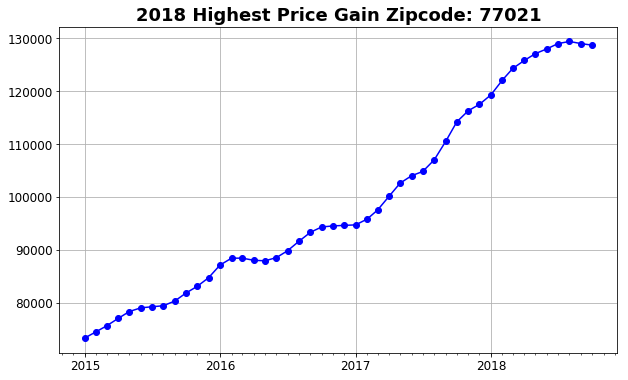

In [7]:
# now let's find out zip code with highest price gain
fig, ax = plt.subplots(figsize=(10,6))
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
pt2018=pt2018.sort_values(by=['PriceChange'])
data_rearranged['Year']=data_rearranged['Year'].astype(int)
pltData=data_rearranged[(data_rearranged['RegionName']==pt2018['RegionName'].iloc[-1])&(data_rearranged['Year']>=2015)]
pltData['Date']=pd.to_datetime(pltData['Date'])
ax.plot(pltData['Date'],pltData['Price'],'bo-')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#ax.format_ydata = pltData['Price']
ax.grid(True)
plt.title('2018 Highest Price Gain Zipcode: '+str(pt2018['RegionName'].iloc[-1]) ,size=18,weight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Question: How Houston ranks against other cities in US?

In [8]:
d=data_rearranged[data_rearranged['Year']==2018]
grouped=d.groupby(['City'], as_index=False)['Price'].median()
grouped=grouped.sort_values('Price',ascending=False)
grouped=grouped.reset_index()

In [9]:
grouped[grouped['City']=='Houston'].index[0]

4191

In [10]:
grouped[grouped['City']=='Los Angeles'].index[0]

296

In [11]:
grouped[grouped['City']=='New York'].index[0]

292

In [12]:
grouped[grouped['City']=='Chicago'].index[0]

1312

In [13]:
grouped.head()

,index,City,Price
0,246,Atherton,6795400.0
1,5259,Palm Beach,4691100.0
2,3933,Los Altos,3808150.0
3,5645,Portola Valley,3724400.0
4,4065,Malibu,3452400.0


In [14]:
grouped.tail()

,index,City,Price
7846,7735,Witt,26250.0
7847,2288,Flint,25100.0
7848,7631,Whitmire,24350.0
7849,1887,Earlington,24250.0
7850,4241,McColl,15000.0


#### As we can see, this is not a valid comparison as small cities tend to dmoniate extreme gains and drops in the databse. We need to compare Houston against larger cities

In [15]:
population_data=pd.read_csv('cities_population_data.csv',encoding = "ISO-8859-1")

In [16]:
removeWords=['city','town','(pt.)','County','village','township']


In [17]:
population_data['NAME'] = population_data['NAME'].str.replace(' city' , '')
population_data['NAME'] = population_data['NAME'].str.replace(' town' , '')
population_data['NAME'] = population_data['NAME'].str.replace(' County' , '')
population_data['NAME'] = population_data['NAME'].str.replace(' village' , '')
population_data['NAME'] = population_data['NAME'].str.replace(' township' , '')
population_data['NAME'] = population_data['NAME'].str.replace(' (pt.)' , '')

In [18]:
grouped_withPopulation = pd.merge(grouped, population_data,  how='left', left_on=['City'], right_on = ['NAME'])

In [19]:
grouped_withPopulation.head()

,index,City,Price,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,...,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017
0,246,Atherton,6795400.0,162.0,6.0,0.0,3092.0,0.0,0.0,0.0,...,6914,6920.0,6918.0,6957.0,7037.0,7103.0,7146.0,7180.0,7252.0,7238.0
1,246,Atherton,6795400.0,157.0,6.0,81.0,3092.0,0.0,0.0,1.0,...,6914,6920.0,6918.0,6957.0,7037.0,7103.0,7146.0,7180.0,7252.0,7238.0
2,5259,Palm Beach,4691100.0,162.0,12.0,0.0,54025.0,0.0,0.0,0.0,...,8348,8161.0,8173.0,8230.0,8326.0,8409.0,8500.0,8608.0,8704.0,8751.0
3,5259,Palm Beach,4691100.0,50.0,12.0,99.0,0.0,0.0,0.0,0.0,...,1320134,1320135.0,1323753.0,1337065.0,1356257.0,1378497.0,1402065.0,1428378.0,1453768.0,1471150.0
4,5259,Palm Beach,4691100.0,157.0,12.0,99.0,54025.0,0.0,0.0,1.0,...,8348,8161.0,8173.0,8230.0,8326.0,8409.0,8500.0,8608.0,8704.0,8751.0


In [20]:
OneMillion=grouped_withPopulation[grouped_withPopulation['POPESTIMATE2017']>=10**6]
OneMillion=OneMillion.sort_values('Price',ascending=False)
OneMillion=OneMillion.reset_index()
OneMillion[OneMillion['City']=='Houston'].index[0]

42

In [21]:
len(OneMillion)

57

In [22]:
OneMillion

,level_0,index,City,Price,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,...,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017
0,3,5259,Palm Beach,4691100.0,50.0,12.0,99.0,0.0,0.0,0.0,...,1320134,1320135.0,1323753.0,1337065.0,1356257.0,1378497.0,1402065.0,1428378.0,1453768.0,1471150.0
1,169,6240,Santa Clara,1379400.0,50.0,6.0,85.0,0.0,0.0,0.0,...,1781642,1781671.0,1786542.0,1813812.0,1841868.0,1870935.0,1896246.0,1919220.0,1931575.0,1938153.0
2,267,6196,San Jose,1131900.0,162.0,6.0,0.0,68000.0,0.0,0.0,...,945942,952574.0,955255.0,971352.0,985722.0,1003735.0,1016708.0,1027560.0,1031942.0,1035317.0
3,268,6196,San Jose,1131900.0,157.0,6.0,85.0,68000.0,0.0,0.0,...,945942,952574.0,955255.0,971352.0,985722.0,1003735.0,1016708.0,1027560.0,1031942.0,1035317.0
4,359,42,Alameda,965350.0,50.0,6.0,1.0,0.0,0.0,0.0,...,1510271,1510261.0,1513402.0,1532215.0,1556648.0,1582936.0,1611572.0,1637141.0,1653236.0,1663190.0
5,674,4810,New York,742600.0,40.0,36.0,0.0,0.0,0.0,0.0,...,19378102,19378110.0,19405185.0,19526372.0,19625409.0,19712514.0,19773580.0,19819347.0,19836286.0,19849399.0
6,675,4810,New York,742600.0,162.0,36.0,0.0,51000.0,0.0,0.0,...,8175133,8174959.0,8193703.0,8292688.0,8383504.0,8458642.0,8521135.0,8582459.0,8615426.0,8622698.0
7,676,4810,New York,742600.0,50.0,36.0,61.0,0.0,0.0,0.0,...,1585873,1586184.0,1589217.0,1611550.0,1630367.0,1638790.0,1646521.0,1657183.0,1662164.0,1664727.0
8,684,3934,Los Angeles,739650.0,162.0,6.0,0.0,44000.0,0.0,0.0,...,3792621,3792724.0,3796060.0,3824592.0,3859267.0,3891783.0,3922668.0,3953459.0,3981116.0,3999759.0
9,685,3934,Los Angeles,739650.0,50.0,6.0,37.0,0.0,0.0,0.0,...,9818605,9818696.0,9824490.0,9885998.0,9956152.0,10018604.0,10072695.0,10123248.0,10150558.0,10163507.0


#### Houston single family real estate price is 42nd in US among cities with at least 1 million population